## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    x = input_layer
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
        x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
import tensorflow as tf
import keras.backend as K

"""
# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)
"""
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(ce_w):
    """Define the customized loss."""
    
    ce_w = float(ce_w)
    fo_w = 1. - ce_w
    def loss(y_true, y_pred):
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        fo_loss = focal_loss()(y_true, y_pred)
        return tf.add(tf.multiply(ce_loss, ce_w), tf.multiply(fo_loss, fo_w))
    return loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w=ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s-ce_w-%.2f" % (i, ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________________________

Epoch 8/25
50000/50000 [==============================] - 2s 50us/step - loss: 2.5379 - acc: 0.5726 - val_loss: 3.2455 - val_acc: 0.4737
Epoch 9/25
50000/50000 [==============================] - 3s 50us/step - loss: 2.4236 - acc: 0.5868 - val_loss: 3.2420 - val_acc: 0.4687
Epoch 10/25
50000/50000 [==============================] - 3s 50us/step - loss: 2.3148 - acc: 0.6027 - val_loss: 3.2970 - val_acc: 0.4649
Epoch 11/25
50000/50000 [==============================] - 3s 50us/step - loss: 2.2123 - acc: 0.6168 - val_loss: 3.2173 - val_acc: 0.4837
Epoch 12/25
50000/50000 [==============================] - 3s 50us/step - loss: 2.1161 - acc: 0.6304 - val_loss: 3.1289 - val_acc: 0.4912
Epoch 13/25
50000/50000 [==============================] - 3s 50us/step - loss: 2.0204 - acc: 0.6461 - val_loss: 3.2007 - val_acc: 0.4879
Epoch 14/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.9228 - acc: 0.6605 - val_loss: 3.2917 - val_acc: 0.4786
Epoch 15/25
50000/50000 [===========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 71us/step - loss: 3.3870 - acc: 0.3063 - val_loss: 3.6345 - val_acc: 0.3099
Epoch 2/25
50000/50000 [==============================] - 2s 50us/step - loss: 2.5623 - acc: 0.4206 - val_loss: 2.8111 - val_acc: 0.3866
Epoch 3/25
50000/50000 [==============================] - 2s 49us/step - loss: 2.3427 - acc: 0.4603 - val_loss: 2.4931 - val_acc: 0.4303
Epoch 4/25
50000/50000 [==============================] - 2s 49us/step - loss: 2.2094 - acc: 0.4898 - val_loss: 2.4190 - val_acc: 0.4452
Epoch 5/25
50000/50000 [==============================] - 2s 50us/step - loss: 2.1054 - acc: 0.5085 - val_loss: 2.3753 - val_acc: 0.4453
Epoch 6/25
50000/50000 [==============================] - 2s 50us/step - loss: 2.0204 - acc: 0.5301 - val_loss: 2.3257 - val_acc: 0.4568
Epoch 7/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.9446 - acc: 0.5441 - val_loss: 2.2925 - val_acc

50000/50000 [==============================] - 2s 49us/step - loss: 0.9754 - acc: 0.6721 - val_loss: 1.4646 - val_acc: 0.4913
Epoch 25/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.9541 - acc: 0.6812 - val_loss: 1.4674 - val_acc: 0.4927


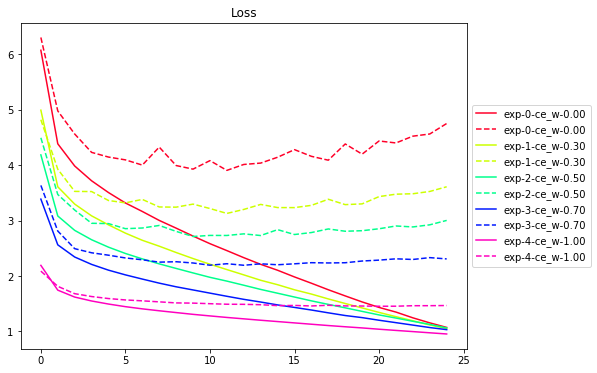

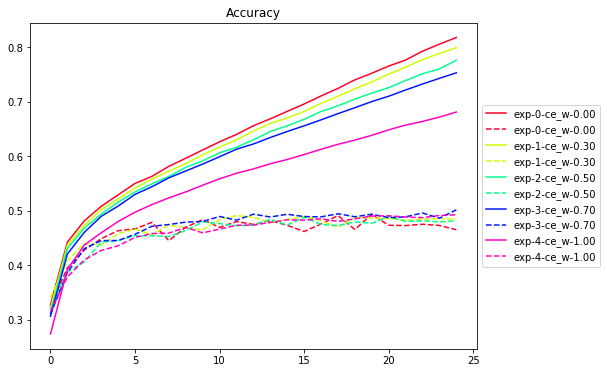

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()